# Mullti-task Learning on Cifar10 Dataset: A CNN Approach
- Name: Minh T. Nguyen, Peter Chen
- ECE 6524 - Final Project
- Date: 4/14/2023
- **Objective**: Build a MTL model for image classification.
    - Task 1: Multi-class classification (airplane, automobile, bird, cat, deer, dog, frog, horse ship, truck).
    - Task 2: Super-class binary classification (animal, vehicle)
    
- **To Do**:
    - Experience with Different Model Configuration: 
        - Optimizers
        - Regularization: Dropout

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import np_utils, plot_model
from keras.layers import Input, Dropout, Flatten, Dense
from keras.applications.resnet import ResNet152, preprocess_input
from keras import Model

In [2]:
tf.version.VERSION

'2.11.0'

# 1. Data Visualization & Preprocessing

# 1.1 Data Visualization

In [3]:
# download data from Keras API
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [4]:
# check dataset size
print(f"X={X_train.shape}, y={y_train.shape}")
print(f"X={X_test.shape}, y={y_test.shape}")

X=(50000, 32, 32, 3), y=(50000, 1)
X=(10000, 32, 32, 3), y=(10000, 1)


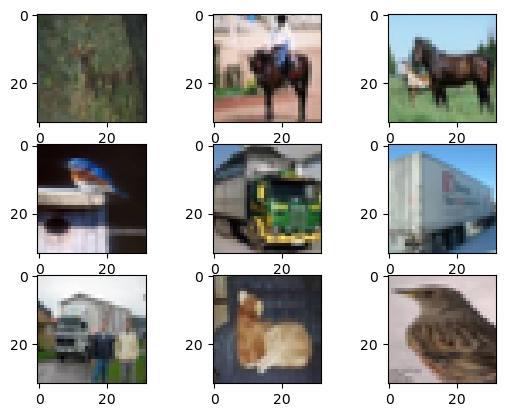

In [5]:
# plot the 9 images
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(X_train[10])
axarr[0,1].imshow(X_train[11])
axarr[0,2].imshow(X_train[12])
axarr[1,0].imshow(X_train[13])
axarr[1,1].imshow(X_train[14])
axarr[1,2].imshow(X_train[15])
axarr[2,0].imshow(X_train[16])
axarr[2,1].imshow(X_train[17])
axarr[2,2].imshow(X_train[18])
plt.show()

## 1.2. Creating Superclasses
The super-classes are divided into animals and vehicles:
- **Animals**: Bird, Cat, Deer, Dog, Frog, Horse. (5000x6 training images, 1000x6 testing images).
- **Vehicles**: Airplane, Automotive, Ship, Truck. (5000x4 training images, 1000x4 testing images).

From [Cifar 10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html), we know that the labels have the corresponding label number:
- Airplane: 0.
- Automobile: 1.
- Bird: 2.
- Cat: 3.
- Deer: 4.
- Dog: 5.
- Frog: 6.
- Horse: 7.
- Ship: 8.
- Truck 9.

In [6]:
# define superclasses (0 = animal, 1 = vehicle)
animal_classes = [2, 3, 4, 5, 6, 7]
y_train_super = [0 if y in animal_classes else 1 for y in y_train ] 
y_test_super = [0 if y in animal_classes else 1 for y in y_test]

print(len(y_train_super))
print(len(y_test_super))

50000
10000


In [7]:
# check labels for accuracy (referencing image plotted above)
print(y_train_super[10:19])

[0, 0, 0, 0, 1, 1, 1, 0, 0]


## 1.3. Data Processing

In [8]:
# normalize input data
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

# convert class into one hot encoder
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print('\ny_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

# convert class into one hot encoder
y_train_super = np_utils.to_categorical(y_train_super)
y_test_super = np_utils.to_categorical(y_test_super)

print('\ny_train_super shape: ', y_train_super.shape)
print('y_test_super shape: ', y_test_super.shape)

X_train shape:  (50000, 32, 32, 3)
X_test shape:  (10000, 32, 32, 3)

y_train shape:  (50000, 10)
y_test shape:  (10000, 10)

y_train_super shape:  (50000, 2)
y_test_super shape:  (10000, 2)


# 2. Modeling

In [9]:
# Define ResNet152 CNN model
def create_model(dropout):
    input_shape = (32, 32, 3)
    
    resnet152_base = ResNet152(weights=None, include_top=False, input_shape=input_shape)
    
    
    # shared back-bone: convolution - feature extractor
    inputs = Input(shape=input_shape, name='input')
    shared_branch = resnet152_base(inputs)
    shared_branch = Flatten()(shared_branch)
    shared_branch = Dense(2048, activation='relu')(shared_branch)
    
    # task 1 branch - fully connected for 10-class classification
    task_1_branch = Dense(1024, activation='relu')(shared_branch)
    task_1_branch = Dropout(dropout)(task_1_branch) 
    task_1_branch = Dense(512, activation="relu")(task_1_branch)
    task_1_branch = Dense(256, activation="relu")(task_1_branch)
    task_1_branch = Dense(128, activation="relu")(task_1_branch)
    task_1_branch = Dense(10, activation="softmax", name="task_1_output")(task_1_branch)
    
    # task 1 branch - fully connected for binary superclass classification
    task_2_branch = Dense(512, activation='relu')(shared_branch)
    task_2_branch = Dropout(dropout)(task_2_branch)
    task_2_branch = Dense(256, activation="relu")(task_2_branch)
    task_2_branch = Dense(128, activation="relu")(task_2_branch)
    task_2_branch = Dense(2, activation="softmax", name="task_2_output")(task_2_branch)
    
    # modeling
    model = Model(inputs=inputs, outputs=[task_1_branch, task_2_branch])
    
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resnet152 (Functional)         (None, 1, 1, 2048)   58370944    ['input[0][0]']                  
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['resnet152[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 2048)         4196352     ['flatten[0][0]']                
                                                                                              

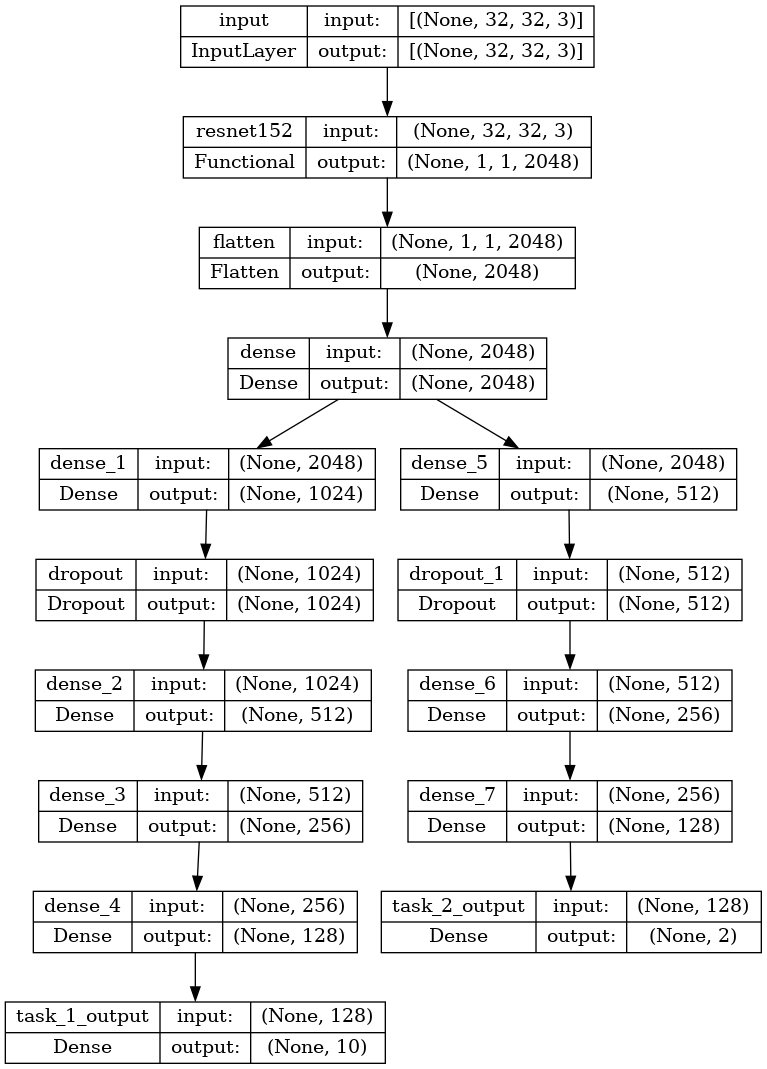

In [10]:
# display and plot model
model = create_model(0)
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# define number of epochs and batch size
epochs = 20
batch_size = 128

## 2.1. Case 1: Gamma = 0.5 - The model will receive the loss evenly in both tasks
##      (Dropout = 0, Optimizer = Adam)

In [12]:
# define parameters and generate model
gamma=0.5
dropout = 0
optimizer = 'Adam'
model_1 = create_model(dropout)

In [13]:
# compile model
model_1.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [14]:
# train model
history_1 = model_1.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
333/333 [==============================] - 156s 147ms/step - loss: 1.2210 - task_1_output_loss: 2.0451 - task_2_output_loss: 0.3969 - task_1_output_accuracy: 0.1795 - task_2_output_accuracy: 0.8203 - val_loss: 1.2197 - val_task_1_output_loss: 2.0282 - val_task_2_output_loss: 0.4112 - val_task_1_output_accuracy: 0.1979 - val_task_2_output_accuracy: 0.8091
Epoch 2/20
333/333 [==============================] - 45s 136ms/step - loss: 1.0519 - task_1_output_loss: 1.8433 - task_2_output_loss: 0.2605 - task_1_output_accuracy: 0.2394 - task_2_output_accuracy: 0.8969 - val_loss: 1.2476 - val_task_1_output_loss: 2.0851 - val_task_2_output_loss: 0.4100 - val_task_1_output_accuracy: 0.2496 - val_task_2_output_accuracy: 0.8779
Epoch 3/20
333/333 [==============================] - 45s 136ms/step - loss: 0.9321 - task_1_output_loss: 1.6381 - task_2_output_loss: 0.2261 - task_1_output_accuracy: 0.3441 - task_2_output_accuracy: 0.9118 - val_loss: 1.0000 - val_task_1_output_loss: 1.7196 - val

In [15]:
# train model results
print('Train loss:', history_1.history['loss'][-1])

print('\nTrain task 1 loss:', history_1.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_1.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_1.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_1.history['task_2_output_accuracy'][-1])

Train loss: 0.35587382316589355

Train task 1 loss: 0.6334853768348694
Train task 1 acc: 0.7843999862670898

Train task 2 loss: 0.07826260477304459
Train task 2 acc: 0.9719529151916504


### Evaluate Model

In [16]:
# test model results
evaluation_results = model_1.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [17]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 0.6660960912704468

Test task 1 loss: 1.1318999528884888
Test task 1 acc: 0.6525999903678894

Test task 2 loss: 0.20029182732105255
Test task 2 acc: 0.9376999735832214


### Plot Results

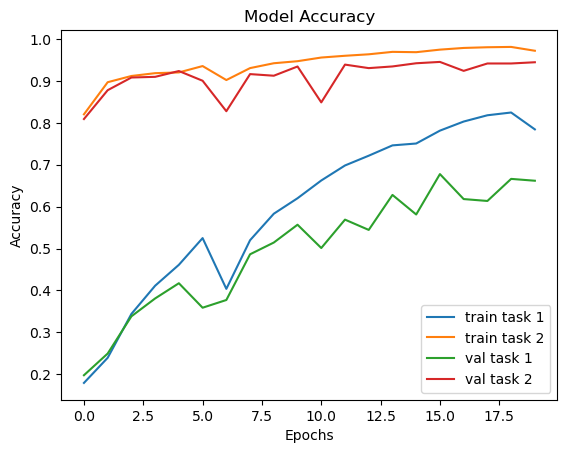

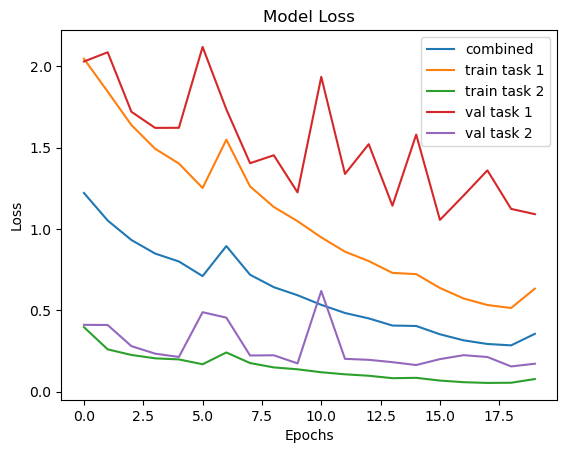

In [18]:
# accuracy plot
plt.plot(history_1.history['task_1_output_accuracy'])
plt.plot(history_1.history['task_2_output_accuracy'])
plt.plot(history_1.history['val_task_1_output_accuracy'])
plt.plot(history_1.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['task_1_output_loss'])
plt.plot(history_1.history['task_2_output_loss'])
plt.plot(history_1.history['val_task_1_output_loss'])
plt.plot(history_1.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.2. Case 2: Gamma = 0.6 - The model will receive loss 60% from task 1, 40% from task 2.
##      (Dropout = 0, Optimizer = Adam)

### Get Model

In [19]:
# define parameters and generate model
gamma=0.6
dropout = 0
optimizer = 'Adam'
model_2 = create_model(dropout)

In [20]:
# compile model
model_2.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [21]:
# train model
history_2 = model_2.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
333/333 [==============================] - 149s 146ms/step - loss: 1.3731 - task_1_output_loss: 2.0190 - task_2_output_loss: 0.4043 - task_1_output_accuracy: 0.1963 - task_2_output_accuracy: 0.8143 - val_loss: 1.2641 - val_task_1_output_loss: 1.8950 - val_task_2_output_loss: 0.3178 - val_task_1_output_accuracy: 0.2376 - val_task_2_output_accuracy: 0.8840
Epoch 2/20
333/333 [==============================] - 46s 138ms/step - loss: 1.1205 - task_1_output_loss: 1.6965 - task_2_output_loss: 0.2566 - task_1_output_accuracy: 0.3097 - task_2_output_accuracy: 0.8979 - val_loss: 1.2492 - val_task_1_output_loss: 1.8650 - val_task_2_output_loss: 0.3255 - val_task_1_output_accuracy: 0.3183 - val_task_2_output_accuracy: 0.8799
Epoch 3/20
333/333 [==============================] - 46s 137ms/step - loss: 1.0860 - task_1_output_loss: 1.6364 - task_2_output_loss: 0.2604 - task_1_output_accuracy: 0.3671 - task_2_output_accuracy: 0.8964 - val_loss: 1.7447 - val_task_1_output_loss: 2.6887 - val

In [22]:
# train model results
print('Train loss:', history_2.history['loss'][-1])

print('\nTrain task 1 loss:', history_2.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_2.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_2.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_2.history['task_2_output_accuracy'][-1])

Train loss: 0.3803514540195465

Train task 1 loss: 0.5870358943939209
Train task 1 acc: 0.801552951335907

Train task 2 loss: 0.07032462954521179
Train task 2 acc: 0.973835289478302


### Evaluate Model

In [23]:
# test model results
evaluation_results = model_2.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [24]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 0.7078489661216736

Test task 1 loss: 1.0460563898086548
Test task 1 acc: 0.6883000135421753

Test task 2 loss: 0.20053784549236298
Test task 2 acc: 0.9488999843597412


### Plot Results

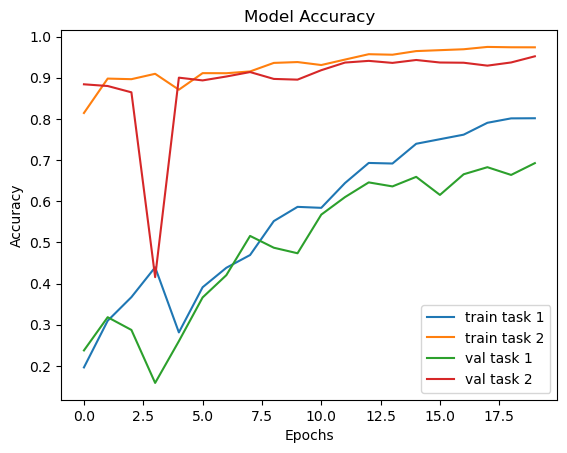

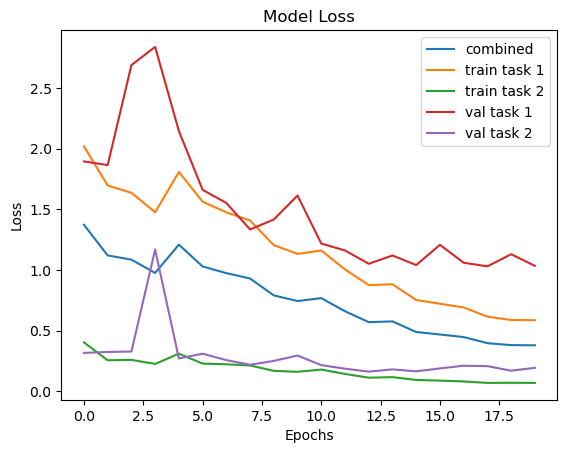

In [25]:
# accuracy plot
plt.plot(history_2.history['task_1_output_accuracy'])
plt.plot(history_2.history['task_2_output_accuracy'])
plt.plot(history_2.history['val_task_1_output_accuracy'])
plt.plot(history_2.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['task_1_output_loss'])
plt.plot(history_2.history['task_2_output_loss'])
plt.plot(history_2.history['val_task_1_output_loss'])
plt.plot(history_2.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.3. Case 3: Gamma = 0.4 - The model will receive loss 40% from task 1, 60% from task 2.
##      (Dropout = 0, Optimizer = Adam)

In [26]:
# define parameters and generate model
gamma=0.4
dropout = 0
optimizer = 'Adam'
model_3 = create_model(dropout)

In [27]:
# compile model
model_3.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [28]:
# train model
history_3 = model_3.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
333/333 [==============================] - 151s 149ms/step - loss: 1.0290 - task_1_output_loss: 2.0046 - task_2_output_loss: 0.3785 - task_1_output_accuracy: 0.1961 - task_2_output_accuracy: 0.8314 - val_loss: 1.0097 - val_task_1_output_loss: 2.0549 - val_task_2_output_loss: 0.3128 - val_task_1_output_accuracy: 0.1949 - val_task_2_output_accuracy: 0.8879
Epoch 2/20
333/333 [==============================] - 50s 149ms/step - loss: 0.8748 - task_1_output_loss: 1.8132 - task_2_output_loss: 0.2492 - task_1_output_accuracy: 0.2469 - task_2_output_accuracy: 0.9010 - val_loss: 1.3783 - val_task_1_output_loss: 2.3734 - val_task_2_output_loss: 0.7148 - val_task_1_output_accuracy: 0.2455 - val_task_2_output_accuracy: 0.8843
Epoch 3/20
333/333 [==============================] - 47s 140ms/step - loss: 0.8362 - task_1_output_loss: 1.7410 - task_2_output_loss: 0.2330 - task_1_output_accuracy: 0.2871 - task_2_output_accuracy: 0.9099 - val_loss: 0.9653 - val_task_1_output_loss: 1.9228 - val

In [29]:
# train model results
print('Train loss:', history_3.history['loss'][-1])

print('\nTrain task 1 loss:', history_3.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_3.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_3.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_3.history['task_2_output_accuracy'][-1])

Train loss: 0.37352028489112854

Train task 1 loss: 0.7982724905014038
Train task 1 acc: 0.7208235263824463

Train task 2 loss: 0.09035204350948334
Train task 2 acc: 0.965929388999939


### Evaluate Model

In [30]:
# test model results
evaluation_results = model_3.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [31]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 0.5265604257583618

Test task 1 loss: 1.0828039646148682
Test task 1 acc: 0.636900007724762

Test task 2 loss: 0.1557309925556183
Test task 2 acc: 0.9458000063896179


### Plot Results

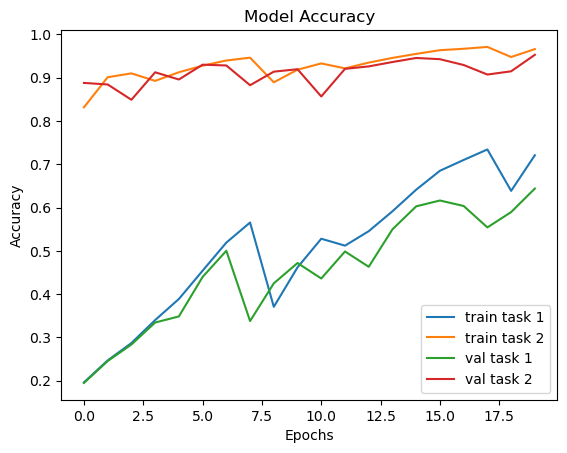

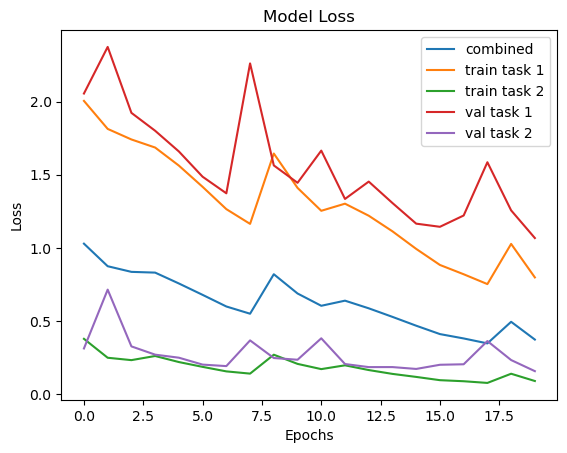

In [32]:
# accuracy plot
plt.plot(history_3.history['task_1_output_accuracy'])
plt.plot(history_3.history['task_2_output_accuracy'])
plt.plot(history_3.history['val_task_1_output_accuracy'])
plt.plot(history_3.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['task_1_output_loss'])
plt.plot(history_3.history['task_2_output_loss'])
plt.plot(history_3.history['val_task_1_output_loss'])
plt.plot(history_3.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.4. Case 4: Gamma = 0.4 - The model will receive loss 40% from task 1 and 60% task 2.
##      (Dropout = 0.4, Optimizer = Adam)

In [33]:
# define parameters and generate model
gamma=0.4
dropout = 0.4
optimizer = 'Adam'
model_4 = create_model(dropout)

In [34]:
# compile model
model_4.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [35]:
# train model
history_4 = model_4.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
333/333 [==============================] - 154s 151ms/step - loss: 1.0842 - task_1_output_loss: 2.0675 - task_2_output_loss: 0.4286 - task_1_output_accuracy: 0.1708 - task_2_output_accuracy: 0.8009 - val_loss: 0.9555 - val_task_1_output_loss: 1.9304 - val_task_2_output_loss: 0.3055 - val_task_1_output_accuracy: 0.2012 - val_task_2_output_accuracy: 0.8852
Epoch 2/20
333/333 [==============================] - 47s 141ms/step - loss: 0.9099 - task_1_output_loss: 1.8765 - task_2_output_loss: 0.2655 - task_1_output_accuracy: 0.2124 - task_2_output_accuracy: 0.8924 - val_loss: 1.0287 - val_task_1_output_loss: 2.0903 - val_task_2_output_loss: 0.3210 - val_task_1_output_accuracy: 0.1935 - val_task_2_output_accuracy: 0.8940
Epoch 3/20
333/333 [==============================] - 47s 142ms/step - loss: 0.8792 - task_1_output_loss: 1.8214 - task_2_output_loss: 0.2511 - task_1_output_accuracy: 0.2425 - task_2_output_accuracy: 0.9025 - val_loss: 1.9975 - val_task_1_output_loss: 3.1490 - val

In [36]:
# train model results
print('Train loss:', history_4.history['loss'][-1])

print('\nTrain task 1 loss:', history_4.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_4.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_4.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_4.history['task_2_output_accuracy'][-1])

Train loss: 0.5691747069358826

Train task 1 loss: 1.1921175718307495
Train task 1 acc: 0.5612941384315491

Train task 2 loss: 0.15387961268424988
Train task 2 acc: 0.9406353235244751


### Evaluate Model

In [37]:
# test model results
evaluation_results = model_4.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [38]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 0.615700364112854

Test task 1 loss: 1.2916024923324585
Test task 1 acc: 0.5386000275611877

Test task 2 loss: 0.16509844362735748
Test task 2 acc: 0.9365000128746033


### Plot Results

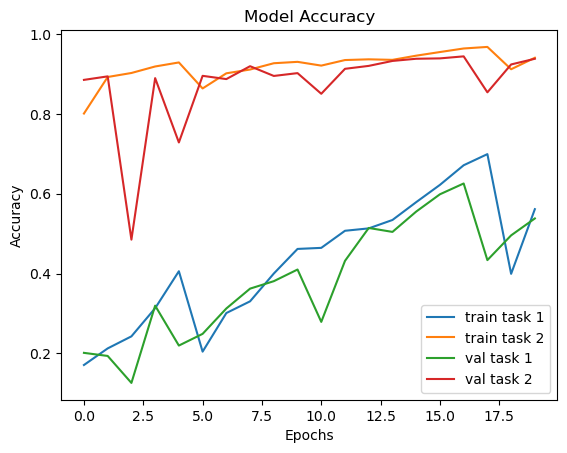

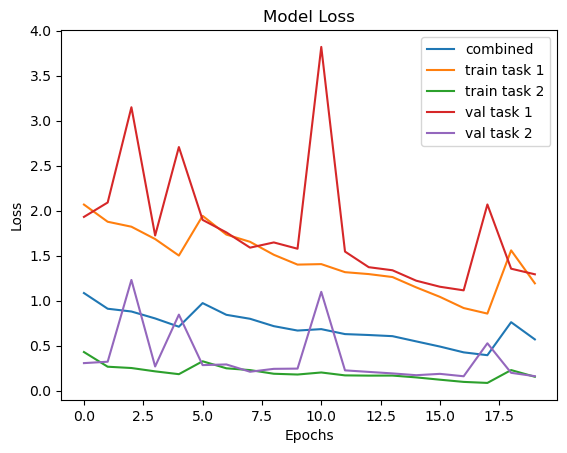

In [39]:
# accuracy plot
plt.plot(history_4.history['task_1_output_accuracy'])
plt.plot(history_4.history['task_2_output_accuracy'])
plt.plot(history_4.history['val_task_1_output_accuracy'])
plt.plot(history_4.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['task_1_output_loss'])
plt.plot(history_4.history['task_2_output_loss'])
plt.plot(history_4.history['val_task_1_output_loss'])
plt.plot(history_4.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.5. Case 5: Gamma = 0.4 - The model will receive loss 40% from task 1 and 60% task 2.
##      (Dropout = 0.4, Optimizer = SGD)

In [40]:
# define parameters and generate model
gamma=0.4
dropout = 0.4
optimizer = 'SGD'
model_5 = create_model(dropout)

In [41]:
# compile model
model_5.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [42]:
# train model
history_5 = model_5.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
333/333 [==============================] - 94s 145ms/step - loss: 1.2262 - task_1_output_loss: 2.2258 - task_2_output_loss: 0.5597 - task_1_output_accuracy: 0.1555 - task_2_output_accuracy: 0.7139 - val_loss: 3.2276 - val_task_1_output_loss: 4.7804 - val_task_2_output_loss: 2.1924 - val_task_1_output_accuracy: 0.1208 - val_task_2_output_accuracy: 0.6532
Epoch 2/20
333/333 [==============================] - 45s 134ms/step - loss: 1.0661 - task_1_output_loss: 2.0230 - task_2_output_loss: 0.4282 - task_1_output_accuracy: 0.2146 - task_2_output_accuracy: 0.8089 - val_loss: 1.6619 - val_task_1_output_loss: 2.8150 - val_task_2_output_loss: 0.8932 - val_task_1_output_accuracy: 0.1261 - val_task_2_output_accuracy: 0.6513
Epoch 3/20
333/333 [==============================] - 45s 135ms/step - loss: 0.9709 - task_1_output_loss: 1.8904 - task_2_output_loss: 0.3579 - task_1_output_accuracy: 0.2659 - task_2_output_accuracy: 0.8448 - val_loss: 1.2395 - val_task_1_output_loss: 2.4373 - val_

In [43]:
# train model results
print('Train loss:', history_5.history['loss'][-1])

print('\nTrain task 1 loss:', history_5.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_5.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_5.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_5.history['task_2_output_accuracy'][-1])

Train loss: 0.59050452709198

Train task 1 loss: 1.2459261417388916
Train task 1 acc: 0.5348705649375916

Train task 2 loss: 0.15355654060840607
Train task 2 acc: 0.9399058818817139


### Evaluate Model

In [44]:
# test model results
evaluation_results = model_5.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [45]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 0.7941854000091553

Test task 1 loss: 1.525551676750183
Test task 1 acc: 0.44999998807907104

Test task 2 loss: 0.3066078722476959
Test task 2 acc: 0.8738999962806702


### Plot Results

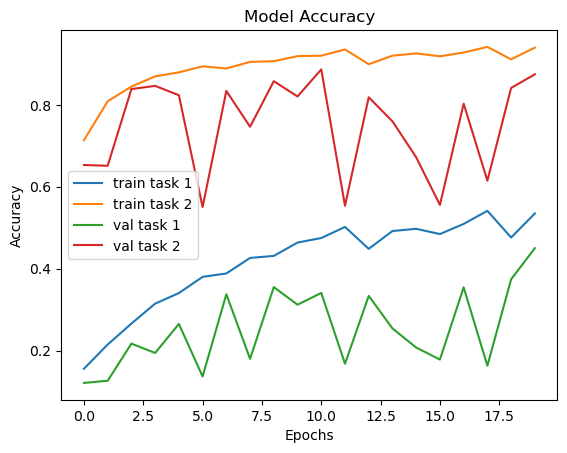

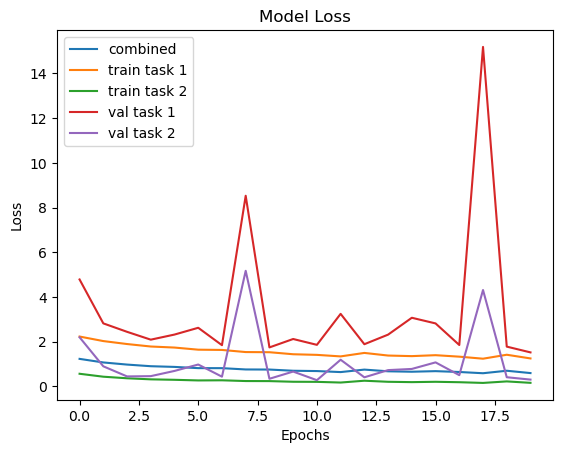

In [46]:
# accuracy plot
plt.plot(history_5.history['task_1_output_accuracy'])
plt.plot(history_5.history['task_2_output_accuracy'])
plt.plot(history_5.history['val_task_1_output_accuracy'])
plt.plot(history_5.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['task_1_output_loss'])
plt.plot(history_5.history['task_2_output_loss'])
plt.plot(history_5.history['val_task_1_output_loss'])
plt.plot(history_5.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()